In [124]:
import numpy as np
import pandas as pd
import gc

import matplotlib.pyplot as plt
%matplotlib inline

#models
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

#validation
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

#succes metrics
import ml_metrics as metrics
from ml_metrics import auc
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score, classification_report

#imbalanced dataset
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import collections

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Najpierw wgrajmy dane

In [125]:
injury_df_ext = pd.read_csv('injury_df_ext.csv')
injury_df = pd.read_csv('InjuryRecord.csv')
play_list_df = pd.read_csv('play_list_df.csv')
#track_injury_df = pd.read_csv('track_injury_df.csv')

Do injury_df dorzucamy brakujące dane w kolumnie 'PlayKey'

In [126]:
injury_df['new']='-1'
injury_df['PlayKey'].fillna(injury_df['GameID']+injury_df['new'], inplace=True)
del injury_df['new']

Widzimy, że bardzo dużo danych ma temp -999, czyli brakuje danych

In [127]:
play_list_df['Temperature'].value_counts()

-999    24170
 68     14127
 72      6970
 61      6744
 71      6261
 48      6068
 60      5982
 62      5897
 80      5797
 79      5775
 46      5575
 63      5388
 44      5384
 70      5322
 89      5245
 84      5229
 53      5208
 42      4749
 65      4577
 33      4493
 54      4404
 55      4403
 51      4395
 56      4185
 82      4066
 76      3963
 66      3895
 69      3835
 83      3765
 39      3746
 40      3656
 73      3564
 81      3470
 52      3367
 77      3256
 43      3247
 78      3199
 45      3191
 57      3082
 67      2941
 50      2707
 58      2706
 86      2659
 47      2654
 35      2372
 75      2369
 64      2354
 87      2274
 36      2190
 74      2166
 88      2143
 49      1956
 37      1936
 90      1866
 59      1851
 25      1686
 29      1618
 91      1612
 85      1572
 38      1429
 23      1224
 31      1131
 19       848
 41       840
 27       828
 28       789
 16       756
 13       745
 97       691
 22       652
 24       616
 92   

Zastępujemy wartości -999 średnią temperatur dla danego rodzaju stadionu

In [128]:
play_list_df['Temperature'] = play_list_df['Temperature'].replace(-999, np.NaN)
play_list_df['Temperature'] = play_list_df.groupby('StadiumType_cat')['Temperature'].transform(lambda x: x.fillna(x.mean()))


Sprawdzamy jak wygląda histogram zmiennej 'Temperature'

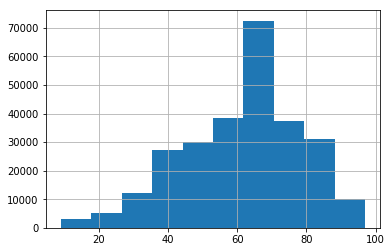

In [129]:
play_list_df['Temperature'].hist()

Łączymy zbiory, Mamy 3 kolumny, które powtarzają się w obu zbiorach ('PlayerKey','GameID' i 'PlayKey'. W pierwszym zbiorze mamy 16 kolumn, w drugim 9, więc po połączeniu powinniśmy dostać 16+9-3=22 kolumny. Nowy zbiór nazywamy oddzielną nazwą 'play_injury_df'

In [130]:
play_list_df.columns, injury_df.columns

(Index(['PlayerKey', 'GameID', 'PlayKey', 'RosterPosition', 'PlayerDay', 'PlayerGame', 'StadiumType', 'FieldType', 'Temperature', 'Weather', 'PlayType', 'PlayerGamePlay', 'Position', 'PositionGroup', 'Weather_cat', 'StadiumType_cat'], dtype='object'),
 Index(['PlayerKey', 'GameID', 'PlayKey', 'BodyPart', 'Surface', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42'], dtype='object'))

In [131]:
play_injury_df = play_list_df.merge(injury_df, how='left')
play_injury_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267006 entries, 0 to 267005
Data columns (total 22 columns):
PlayerKey          267006 non-null int64
GameID             267006 non-null object
PlayKey            267006 non-null object
RosterPosition     267006 non-null object
PlayerDay          267006 non-null int64
PlayerGame         267006 non-null int64
StadiumType        250096 non-null object
FieldType          267006 non-null object
Temperature        267006 non-null float64
Weather            248315 non-null object
PlayType           266639 non-null object
PlayerGamePlay     267006 non-null int64
Position           267006 non-null object
PositionGroup      267006 non-null object
Weather_cat        267006 non-null object
StadiumType_cat    267006 non-null object
BodyPart           105 non-null object
Surface            105 non-null object
DM_M1              105 non-null float64
DM_M7              105 non-null float64
DM_M28             105 non-null float64
DM_M42             105

In [132]:
play_injury_df.head()

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup,Weather_cat,StadiumType_cat,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
0,26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63.0,Clear and warm,Pass,1,QB,QB,sun,outdoor,NaN,NaN,NaN,NaN,NaN,NaN
1,26624,26624-1,26624-1-2,Quarterback,1,1,Outdoor,Synthetic,63.0,Clear and warm,Pass,2,QB,QB,sun,outdoor,NaN,NaN,NaN,NaN,NaN,NaN
2,26624,26624-1,26624-1-3,Quarterback,1,1,Outdoor,Synthetic,63.0,Clear and warm,Rush,3,QB,QB,sun,outdoor,NaN,NaN,NaN,NaN,NaN,NaN
3,26624,26624-1,26624-1-4,Quarterback,1,1,Outdoor,Synthetic,63.0,Clear and warm,Rush,4,QB,QB,sun,outdoor,NaN,NaN,NaN,NaN,NaN,NaN
4,26624,26624-1,26624-1-5,Quarterback,1,1,Outdoor,Synthetic,63.0,Clear and warm,Pass,5,QB,QB,sun,outdoor,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
#usuwamy niepotrzebne kolumny
if 'BodyPart' in play_injury_df: del play_injury_df['BodyPart']
if 'Surface' in play_injury_df: del play_injury_df['Surface']

In [134]:
#brakujące wartości w kolumnach DM zamieniamy na 0
injury_dm = ['DM_M1', 'DM_M7', 'DM_M28', 'DM_M42']
for injury in injury_dm:
    play_injury_df[injury] = play_injury_df[injury].fillna(0).astype(int)

In [135]:
#dodajemy kolumnę IsInjured, którą zmieniamy na wartości 0 i 1, to będzie nasza zmienna docelowa
play_injury_df['IsInjured']=play_injury_df[['DM_M1','DM_M7','DM_M28','DM_M42']].sum(axis=1)
play_injury_df['IsInjured']=play_injury_df['IsInjured'].map(lambda x: 1 if x>0 else 0)

In [136]:
play_injury_df.columns

Index(['PlayerKey', 'GameID', 'PlayKey', 'RosterPosition', 'PlayerDay', 'PlayerGame', 'StadiumType', 'FieldType', 'Temperature', 'Weather', 'PlayType', 'PlayerGamePlay', 'Position', 'PositionGroup', 'Weather_cat', 'StadiumType_cat', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42', 'IsInjured'], dtype='object')

In [137]:
#usuwamy niepotrzebne kolumny
play_injury_df = play_injury_df.drop(columns=['GameID', 'PlayerKey', 'PlayKey', 'StadiumType', 'Weather','Position','DM_M1', 'DM_M7',
       'DM_M28', 'DM_M42'])

Zostaje nam 11 kolumn, ale tylko kilka z nim ma wartości numeryczne. Musimy zamienić zmienne kategorialne na wartości numeryczne. Użyjemy do tego funkcji 'get_dummies'

In [138]:
play_injury_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267006 entries, 0 to 267005
Data columns (total 11 columns):
RosterPosition     267006 non-null object
PlayerDay          267006 non-null int64
PlayerGame         267006 non-null int64
FieldType          267006 non-null object
Temperature        267006 non-null float64
PlayType           266639 non-null object
PlayerGamePlay     267006 non-null int64
PositionGroup      267006 non-null object
Weather_cat        267006 non-null object
StadiumType_cat    267006 non-null object
IsInjured          267006 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 24.4+ MB


In [139]:
#Zmieniamy zmienne kategorialne na wartości liczbowe, bo model rozpoznaje tylko wartości numeryczne
cat_features = play_injury_df.select_dtypes(include= np.object).columns
play_injury_df_cat = pd.get_dummies(play_injury_df, columns=cat_features, drop_first=True)
play_injury_df_cat = play_injury_df_cat.drop(columns=['PlayerDay', 'PlayerGame', 'Temperature', 'PlayerGamePlay', 'IsInjured'])
play_injury_df = pd.concat([play_injury_df, play_injury_df_cat], axis=1)

Powstaje nam zbiór z 50 kolumnami

In [140]:
play_injury_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267006 entries, 0 to 267005
Data columns (total 50 columns):
RosterPosition                      267006 non-null object
PlayerDay                           267006 non-null int64
PlayerGame                          267006 non-null int64
FieldType                           267006 non-null object
Temperature                         267006 non-null float64
PlayType                            266639 non-null object
PlayerGamePlay                      267006 non-null int64
PositionGroup                       267006 non-null object
Weather_cat                         267006 non-null object
StadiumType_cat                     267006 non-null object
IsInjured                           267006 non-null int64
RosterPosition_Defensive Lineman    267006 non-null uint8
RosterPosition_Kicker               267006 non-null uint8
RosterPosition_Linebacker           267006 non-null uint8
RosterPosition_Offensive Lineman    267006 non-null uint8
RosterPosit

Zapisujemy dataframe do pliku

In [141]:
play_injury_df.to_csv('play_injury_df.csv', index=False)

Ustalamy, które cechy będziemy brali do modelu, a które nie

In [142]:
feats = play_injury_df.select_dtypes(include= np.number).columns #in feats we list only numerical
black_list = ['IsInjured'] #zmienna docelowa
feats = [feat for feat in feats if feat not in black_list]

In [143]:
#training data
X_df = play_injury_df[feats]
X_train = X_df.values
y_train = play_injury_df['IsInjured'].values.astype(np.int8)

In [144]:
#list of models
models = [
        xgb.XGBClassifier(random_state=8888,max_depth=5, n_estimators=100, objective='binary:logistic'),
        LogisticRegression(random_state=8888,solver='lbfgs', max_iter=1000),
        DecisionTreeClassifier(random_state=8888),
        RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=10, min_samples_leaf=5,random_state=2019),
        ] 

In [145]:
#opisać co się dzieje w funkcji, jak wygląda cross walidacja i dlaczego wybieramy f1 jako metrykę sukcesu
def model_train_predict(X, y, model, folds=3, succes_metric1=accuracy_score, succes_metric2=recall_score, succes_metric3=precision_score, succes_metric4=f1_score):
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=8888)
    accu_scores = []
    f1_scores = []
    recall_scores=[]
    precision_scores = []
    for train_idx, test_idx in cv.split(X,y):
        X_fold_train, X_fold_test = X[train_idx], X[test_idx]
        y_fold_train, y_fold_test = y[train_idx], y[test_idx]
        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_test)
        
        accu_score = succes_metric1(y[test_idx], y_pred)
        accu_scores.append(accu_score)
        
        recall_score = succes_metric2(y[test_idx], y_pred)
        recall_scores.append(recall_score)
        
        precision_score = succes_metric3(y[test_idx], y_pred)
        precision_scores.append(precision_score)
        
        f1_score = succes_metric4(y[test_idx], y_pred)
        f1_scores.append(f1_score)
        
    print('Mean accuracy score= ', np.mean(accu_scores), ', standard deviation (std)=' , np.std(accu_scores) )
    print('Mean recall score= ', np.mean(recall_scores), ', standard deviation (std)=' , np.std(recall_scores) )
    print('Mean precision score= ', np.mean(precision_scores), ', standard deviation (std)=' , np.std(precision_scores) )
    print('Mean f1 score= ', np.mean(f1_scores), ', standard deviation (std)=' , np.std(f1_scores) )

In [146]:
for i in range (0,len(models)):
    print ('Model: ', models[i])
    model = models[i]
    model_train_predict(X_train, y_train, model)
    print('______________________________________________________________________________')

Model:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=8888, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)


C:\Users\ajankowski\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ajankowski\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Mean accuracy score=  0.9996067504101033 , standard deviation (std)= 1.1102230246251565e-16
Mean recall score=  0.0 , standard deviation (std)= 0.0
Mean precision score=  0.0 , standard deviation (std)= 0.0
Mean f1 score=  0.0 , standard deviation (std)= 0.0
______________________________________________________________________________
Model:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=8888, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)


C:\Users\ajankowski\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ajankowski\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ajankowski\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ajankowski\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_fo

Mean accuracy score=  0.9996067504101033 , standard deviation (std)= 1.1102230246251565e-16
Mean recall score=  0.0 , standard deviation (std)= 0.0
Mean precision score=  0.0 , standard deviation (std)= 0.0
Mean f1 score=  0.0 , standard deviation (std)= 0.0
______________________________________________________________________________
Model:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=8888,
            splitter='best')
Mean accuracy score=  0.9991760484783114 , standard deviation (std)= 7.125794023520341e-05
Mean recall score=  0.019047619047619046 , standard deviation (std)= 0.013468700594029477
Mean precision score=  0.018575851393188854 , standard deviation (std)= 0.013195781065577318
Mean f1 score=  0.018794255840

C:\Users\ajankowski\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ajankowski\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ajankowski\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ajankowski\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pre

Mean accuracy score=  0.9996067504101033 , standard deviation (std)= 1.1102230246251565e-16
Mean recall score=  0.0 , standard deviation (std)= 0.0
Mean precision score=  0.0 , standard deviation (std)= 0.0
Mean f1 score=  0.0 , standard deviation (std)= 0.0
______________________________________________________________________________


C:\Users\ajankowski\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ajankowski\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [147]:
play_injury_df['IsInjured'].value_counts()

0    266901
1       105
Name: IsInjured, dtype: int64

RANDOM UNDER SAMPLER

In [148]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [149]:
for i in range (0,len(models)):
    print ('Model: ', models[i])
    model = models[i]
    model_train_predict(X_resampled, y_resampled, model)
    print('______________________________________________________________________________')

Model:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=8888, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)
Mean accuracy score=  0.7285714285714286 , standard deviation (std)= 0.020203050891044246
Mean recall score=  0.6761904761904761 , standard deviation (std)= 0.048562090605645584
Mean precision score=  0.7564313081554461 , standard deviation (std)= 0.0262209856504292
Mean f1 score=  0.7128434065934065 , standard deviation (std)= 0.027239568607726413
______________________________________________________________________________
Model:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, 

RANDOM OVER SAMPLER

In [150]:
#dodajemy do funkcji RandomOverSampler
res = RandomOverSampler(random_state=8888)
X_resampled, y_resampled = res.fit_resample(X_train, y_train)

In [151]:
np.count_nonzero(y_resampled)

266901

In [152]:
for i in range (0,len(models)):
    print ('Model: ', models[i])
    model = models[i]
    model_train_predict(X_resampled, y_resampled, model)
    print('______________________________________________________________________________')

Model:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=8888, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)
Mean accuracy score=  0.9668809783402835 , standard deviation (std)= 0.0004093267314788447
Mean recall score=  1.0 , standard deviation (std)= 0.0
Mean precision score=  0.9378774243167544 , standard deviation (std)= 0.000720423255394838
Mean f1 score=  0.9679428372234086 , standard deviation (std)= 0.00038359278273442896
______________________________________________________________________________
Model:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
       

C:\Users\ajankowski\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ajankowski\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ajankowski\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Mean accuracy score=  0.7072828501953907 , standard deviation (std)= 0.002676260137883818
Mean recall score=  0.7093041989351856 , standard deviation (std)= 0.0036818260771827095
Mean precision score=  0.7064443618591736 , standard deviation (std)= 0.0022922211232444057
Mean f1 score=  0.7078704381527151 , standard deviation (std)= 0.0029499962731188807
______________________________________________________________________________
Model:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=8888,
            splitter='best')
Mean accuracy score=  0.9997208702852368 , standard deviation (std)= 6.888238077360195e-05
Mean recall score=  1.0 , standard deviation (std)= 0.0
Mean precision score=  0.9994420709957129 , standard deviati

In [153]:
def draw_feature_importances(model, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 5))
    plt.title("Feature importances")
    plt.bar(range(X_resampled.shape[1]), model.feature_importances_[indices],
    color="b", align="center")
    plt.xticks(range(X_resampled.shape[1]), [ features[x-3] for x in indices])
    plt.xticks(rotation=90)
    plt.xlim([-1, X_resampled.shape[1]])
    plt.show()

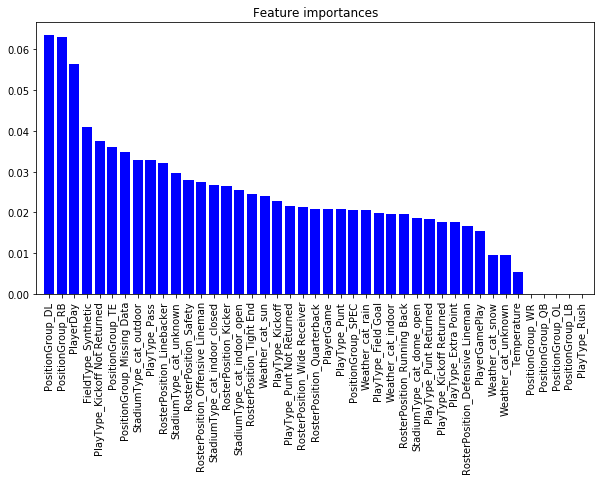

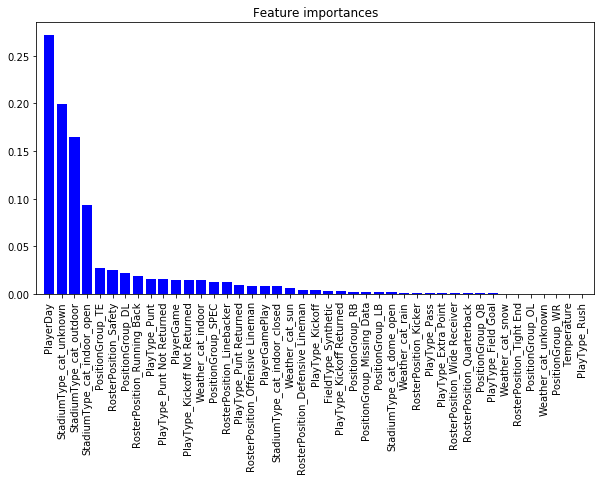

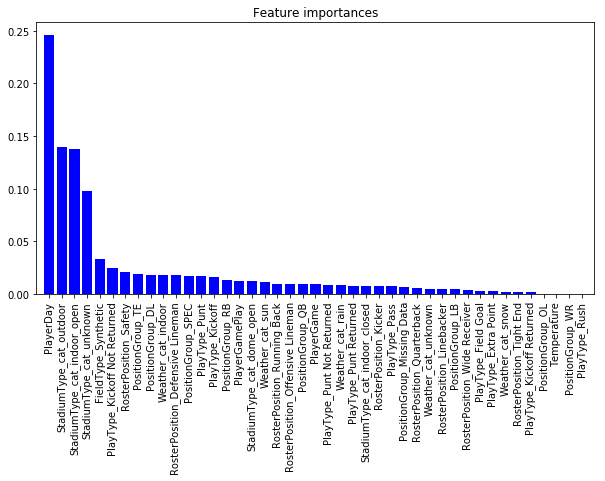

In [154]:
for i in [0,2,3]:
    draw_feature_importances(models[i], feats)

SMOTE

In [155]:
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
print(sorted(collections.Counter(y_resampled).items()))

[(0, 266901), (1, 266901)]


In [156]:
for i in range (0,len(models)):
    print ('Model: ', models[i])
    model = models[i]
    model_train_predict(X_resampled, y_resampled, model)
    print('______________________________________________________________________________')

Model:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=8888, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)
Mean accuracy score=  0.9994192603249895 , standard deviation (std)= 6.964241533542634e-05
Mean recall score=  0.9989921356607881 , standard deviation (std)= 8.913700026130658e-05
Mean precision score=  0.9998462517529259 , standard deviation (std)= 5.0594130093622314e-05
Mean f1 score=  0.9994190108217591 , standard deviation (std)= 6.96827756107983e-05
______________________________________________________________________________
Model:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=

C:\Users\ajankowski\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ajankowski\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ajankowski\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Mean accuracy score=  0.727554411560841 , standard deviation (std)= 0.0008022111290165455
Mean recall score=  0.7376780154439286 , standard deviation (std)= 0.002340753874356988
Mean precision score=  0.7230500810521137 , standard deviation (std)= 0.002015178679136557
Mean f1 score=  0.7302845466985844 , standard deviation (std)= 0.00042859939029115047
______________________________________________________________________________
Model:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=8888,
            splitter='best')
Mean accuracy score=  0.9994660941697484 , standard deviation (std)= 5.1098278751239137e-05
Mean recall score=  0.9995091813069266 , standard deviation (std)= 3.7090512724252384e-05
Mean precision score=  0.9

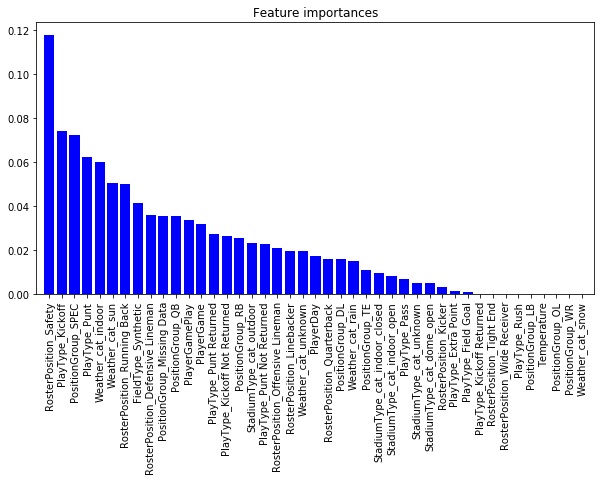

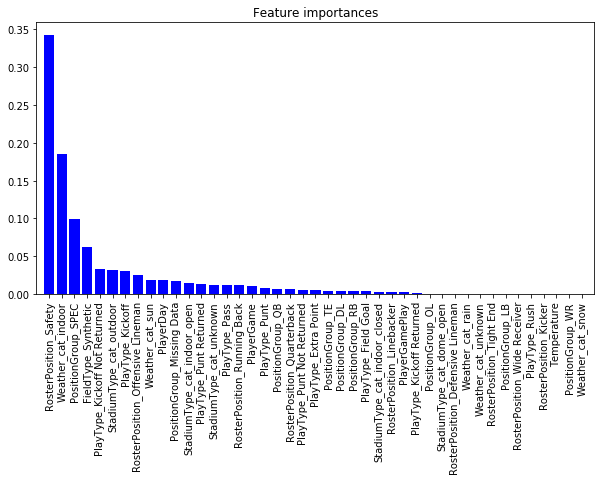

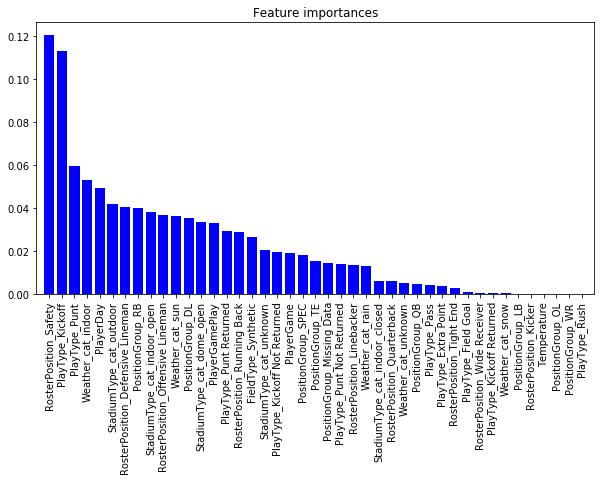

In [157]:
for i in [0,2,3]:
    draw_feature_importances(models[i], feats)

OVERSAMPLING AFTER CROSS_VALIDATION

In [158]:
def model_train_oversample_predict(X, y, model, folds=3, succes_metric1=accuracy_score, succes_metric2=recall_score, succes_metric3=precision_score, succes_metric4=f1_score):
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=2019)
    res = RandomOverSampler(random_state=8888)
    accu_scores = []
    f1_scores = []
    recall_scores=[]
    precision_scores = []
    for train_idx, test_idx in cv.split(X,y):
        X_fold_train, X_fold_test = X[train_idx], X[test_idx]
        y_fold_train, y_fold_test = y[train_idx], y[test_idx]
        X_resampled, y_resampled = res.fit_resample(X_fold_train, y_fold_train)
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_fold_test)
        
        accu_score = succes_metric1(y[test_idx], y_pred)
        accu_scores.append(accu_score)
        
        recall_score = succes_metric2(y[test_idx], y_pred)
        recall_scores.append(recall_score)
        
        precision_score = succes_metric3(y[test_idx], y_pred)
        precision_scores.append(precision_score)
        
        f1_score = succes_metric4(y[test_idx], y_pred)
        f1_scores.append(f1_score)
        
    print('Mean accuracy score= ', np.mean(accu_scores), ', standard deviation (std)=' , np.std(accu_scores) )
    print('Mean recall score= ', np.mean(recall_scores), ', standard deviation (std)=' , np.std(recall_scores) )
    print('Mean precision score= ', np.mean(precision_scores), ', standard deviation (std)=' , np.std(precision_scores) )
    print('Mean f1 score= ', np.mean(f1_scores), ', standard deviation (std)=' , np.std(f1_scores) )

In [159]:
for i in range (0,len(models)):
    print ('Model: ', models[i])
    model = models[i]
    model_train_oversample_predict(X_train, y_train, model)
    print('______________________________________________________________________________')

Model:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=8888, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)
Mean accuracy score=  0.9571320494670532 , standard deviation (std)= 0.004319133583193222
Mean recall score=  0.11428571428571428 , standard deviation (std)= 0.023328473740792166
Mean precision score=  0.0010799853942164341 , standard deviation (std)= 0.00028180812728710423
Mean f1 score=  0.0021395969599105817 , standard deviation (std)= 0.0005571897427213868
______________________________________________________________________________
Model:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max

C:\Users\ajankowski\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ajankowski\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ajankowski\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Mean accuracy score=  0.7110289656412215 , standard deviation (std)= 0.020656349495058565
Mean recall score=  0.5714285714285715 , standard deviation (std)= 0.12121830534626528
Mean precision score=  0.0007691909388305391 , standard deviation (std)= 0.00011560241307252394
Mean f1 score=  0.0015363040609235566 , standard deviation (std)= 0.0002310307057024865
______________________________________________________________________________
Model:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=8888,
            splitter='best')
Mean accuracy score=  0.9992060103518273 , standard deviation (std)= 0.00012387613318459977
Mean recall score=  0.019047619047619046 , standard deviation (std)= 0.013468700594029477
Mean precision score

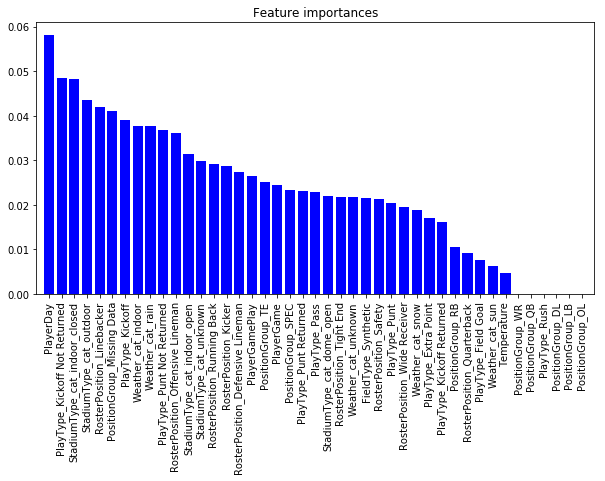

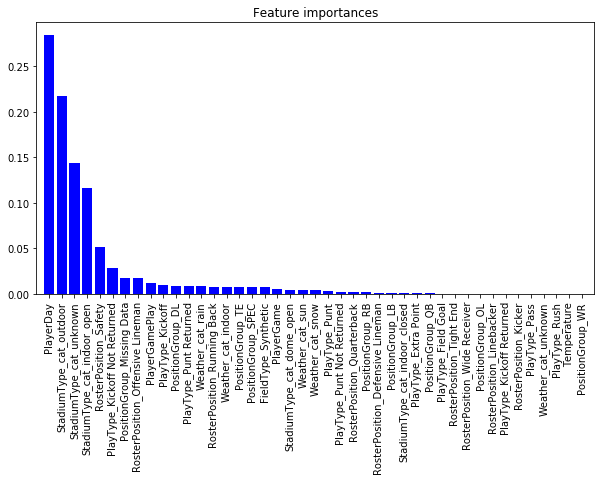

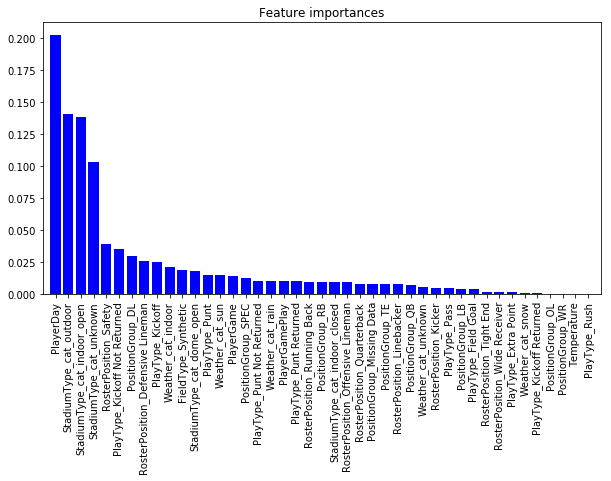

In [160]:
for i in [0,2,3]:
    draw_feature_importances(models[i], feats)

In [35]:
# for feature importance I'll use ELI5 library
# let use XGB Classifier and see which feature is important

#first let's divide the data for two sets: train and test by train_test_split function
#X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_resampled, y_resampled, shuffle=True, random_state=8888)

In [36]:
#XGBClassifier on training data, %time to check the time needed for model training
#model = xgb.XGBClassifier(random_state=8888, max_depth=5, n_estimators=100, objective='binary:logistic')
#%time model.fit(X_sub_train, y_sub_train)

Wall time: 1min 48s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=8888, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [37]:
#Let's check PermutationImportance on test data
#PermutationImportance checks features importance in such way that it mixes data in each feature column and then runs the model,
#if the model metric doesn't get worse by mixing of values it means that this feature may be random and is not significant

#%time perm = PermutationImportance(model).fit(X_sub_test, y_sub_test)

Wall time: 2min 22s


In [38]:
#feats.append("xxx")
#feats.append("yyy")

In [39]:
#let's see most important 50 features by eli5
#eli_show0=eli5.show_weights(perm, feature_names=feats, top=50)
#eli_show0


Weight,Feature
0.0547 ± 0.0011,Synthetic
0.0195 ± 0.0005,sun
0.0174 ± 0.0003,Wide Receiver
0.0128 ± 0.0005,WR
0.0121 ± 0.0003,Pass
0.0060 ± 0.0001,indoor
0.0052 ± 0.0002,rain
0.0050 ± 0.0002,PlayerGame
0.0031 ± 0.0002,Safety
0.0027 ± 0.0002,PlayerGamePlay


In [40]:
#let's check which features are important for RandomForestClassifier
#X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_resampled, y_resampled, shuffle=True, random_state=8888)

In [41]:
#model = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=10, min_samples_leaf=5,random_state=2019)
#%time model.fit(X_sub_train, y_sub_train)

Wall time: 26.3 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=2019, verbose=0,
            warm_start=False)

In [42]:
#%time perm = PermutationImportance(model).fit(X_sub_test, y_sub_test)

Wall time: 2min 40s


In [43]:
#eli_show1=eli5.show_weights(perm, feature_names=feats, top=50)
#eli_show1

Weight,Feature
0.0149 ± 0.0002,Synthetic
0.0102 ± 0.0005,Pass
0.0102 ± 0.0006,sun
0.0085 ± 0.0003,PlayerGame
0.0057 ± 0.0003,PlayerDay
0.0051 ± 0.0003,unknown
0.0051 ± 0.0003,PlayerGamePlay
0.0043 ± 0.0003,Rush
0.0042 ± 0.0002,Temperature
0.0027 ± 0.0002,WR


In [44]:
#play_injury_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267006 entries, 0 to 267005
Data columns (total 50 columns):
RosterPosition          267006 non-null object
PlayerDay               267006 non-null int64
PlayerGame              267006 non-null int64
FieldType               267006 non-null object
Temperature             267006 non-null float64
PlayType                266639 non-null object
PlayerGamePlay          267006 non-null int64
PositionGroup           267006 non-null object
Weather_cat             267006 non-null object
StadiumType_cat         267006 non-null object
IsInjured               267006 non-null int64
Defensive Lineman       267006 non-null uint8
Kicker                  267006 non-null uint8
Linebacker              267006 non-null uint8
Offensive Lineman       267006 non-null uint8
Quarterback             267006 non-null uint8
Running Back            267006 non-null uint8
Safety                  267006 non-null uint8
Tight End               267006 non-null uint8
Wide Re

In [161]:
#sprawdźmy jak wygląda wynik przy ograniczonej ilości danych
feats = play_injury_df.select_dtypes(include= np.number).columns #in feats we list only numerical
black_list = ['RosterPosition',
       'PlayerGamePlay', 'PositionGroup', 'Weather_cat', 'StadiumType_cat',
       'IsInjured', 'Cornerback', 'Defensive Lineman', 'Kicker', 'Linebacker',
       'Offensive Lineman', 'Quarterback', 'Running Back', 'Safety',
       'Tight End', 'Wide Receiver', '0',
       'Extra Point', 'Field Goal', 'Kickoff', 'Kickoff Not Returned',
       'Kickoff Returned', 'Pass', 'Punt', 'Punt Not Returned',
       'Punt Returned', 'Rush', 'DB', 'DL', 'LB', 'Missing Data', 'OL', 'QB',
       'RB', 'SPEC', 'TE', 'WR'] 
feats = [feat for feat in feats if feat not in black_list]

In [162]:
#training data
X_df = play_injury_df[feats]
X_train = X_df.values
y_train = play_injury_df['IsInjured'].values.astype(np.int8)

In [47]:
#dodajemy do funkcji RandomOverSampler
#res = RandomOverSampler(random_state=8888)
#X_resampled, y_resampled = res.fit_resample(X_train, y_train)

In [163]:
for i in range (0,len(models)):
    print ('Model: ', models[i])
    model = models[i]
    model_train_oversample_predict(X_train, y_train, model)
    print('______________________________________________________________________________')

Model:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=8888, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)
Mean accuracy score=  0.9147884317206355 , standard deviation (std)= 0.011397636835522707
Mean recall score=  0.15238095238095237 , standard deviation (std)= 0.09428090415820634
Mean precision score=  0.0006571892495434798 , standard deviation (std)= 0.00036533718403980204
Mean f1 score=  0.0013086779108602148 , standard deviation (std)= 0.00072788884972625
______________________________________________________________________________
Model:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_it

C:\Users\ajankowski\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ajankowski\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ajankowski\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Mean accuracy score=  0.6997258488573291 , standard deviation (std)= 0.024166222788736497
Mean recall score=  0.561904761904762 , standard deviation (std)= 0.15532863266952465
Mean precision score=  0.0007233715657655673 , standard deviation (std)= 0.00015361640766301324
Mean f1 score=  0.0014448726073939251 , standard deviation (std)= 0.000306966993706807
______________________________________________________________________________
Model:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=8888,
            splitter='best')
Mean accuracy score=  0.9937604398403033 , standard deviation (std)= 0.0005504602463902151
Mean recall score=  0.019047619047619046 , standard deviation (std)= 0.013468700594029477
Mean precision score=  

ValueError: shape mismatch: objects cannot be broadcast to a single shape

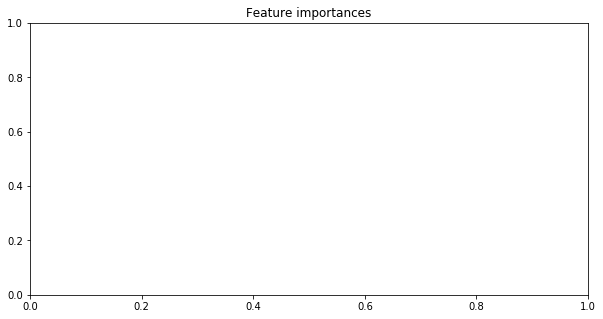

In [164]:
for i in [0,2,3]:
    draw_feature_importances(models[i], feats)